In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Read data

In [5]:
df_train = pd.read_csv('stream_quality_data/train_data.csv')
df_test = pd.read_csv('stream_quality_data/test_data.csv')

# 2. Data Exploration

In [6]:
print('Number of rows and columns in the training data set: ',df_train.shape)
df_train.head(5)

Number of rows and columns in the training data set:  (406572, 12)


,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state,auto_fec_state,auto_fec_mean,stream_quality
0,24.4,0.516398,0,91.1,6.723921,0.0,0.0,0.0,off,partial,50.0,0
1,28.6,2.065591,0,99.7,15.923777,0.0,0.0,0.0,off,partial,50.0,0
2,30.0,0.000000,0,98.1,11.798776,0.0,0.0,0.0,off,partial,50.0,0
3,30.3,0.948683,0,99.4,13.014522,0.0,0.0,0.0,off,partial,50.0,0
4,29.9,0.316228,0,123.2,62.476307,0.0,0.0,0.0,off,partial,50.0,0


In [7]:
types = df_train.dtypes
print("Number categorical featues:", sum(types=='object'))
print(types)

Number categorical featues: 2
fps_mean               float64
fps_std                float64
fps_lags                 int64
rtt_mean               float64
rtt_std                float64
dropped_frames_mean    float64
dropped_frames_std     float64
dropped_frames_max     float64
auto_bitrate_state      object
auto_fec_state          object
auto_fec_mean          float64
stream_quality           int64
dtype: object


In [8]:
df_train_describe = df_train.describe().T
df_train_describe

,count,mean,std,min,25%,50%,75%,max
fps_mean,406572.0,3.449756e+01,1.162549e+01,0.0,28.300000,30.000000,43.000000,1.271000e+02
fps_std,406572.0,2.285486e+00,3.708531e+00,0.0,0.316228,0.994429,2.590581,3.125408e+02
fps_lags,406572.0,1.831508e-01,1.099384e+00,0.0,0.000000,0.000000,0.000000,1.000000e+01
rtt_mean,406572.0,5.431440e+01,1.338721e+02,0.0,14.100000,32.300000,57.100000,1.289840e+04
rtt_std,406572.0,1.952502e+01,1.563643e+02,0.0,0.699206,1.490712,5.334375,4.072193e+04
dropped_frames_mean,406572.0,1.730432e+06,4.930091e+07,0.0,0.000000,0.000000,0.000000,2.097289e+09
dropped_frames_std,406572.0,1.378279e+05,9.229776e+06,0.0,0.000000,0.000000,0.000000,9.963751e+08
dropped_frames_max,406572.0,1.893339e+06,5.241003e+07,0.0,0.000000,0.000000,0.000000,2.097289e+09
auto_fec_mean,406572.0,5.141354e+01,3.483604e+01,0.0,50.000000,50.000000,50.000000,2.500000e+02
stream_quality,406572.0,6.846020e-02,2.525343e-01,0.0,0.000000,0.000000,0.000000,1.000000e+00


In [9]:
df_train.isna().sum()

fps_mean               0
fps_std                0
fps_lags               0
rtt_mean               0
rtt_std                0
dropped_frames_mean    0
dropped_frames_std     0
dropped_frames_max     0
auto_bitrate_state     0
auto_fec_state         0
auto_fec_mean          0
stream_quality         0
dtype: int64

No missing values, 2 categorical features

## 3. Data Preprocessing

### Encoding the categorical features

In [10]:
from sklearn.preprocessing import LabelEncoder


# extracting the names of categorical features
cat_feats = df_train.select_dtypes(include=['object']).columns.tolist()

encoder = LabelEncoder()

# creating a copy of dataset to save our initial data
df_train_encoded = df_train.copy()
df_test_encoded = df_test.copy()

# fit and transform the data 
for name in cat_feats:
    encoder.fit(df_train[name])
    df_train_encoded[name] = encoder.transform(df_train[name])
    df_test_encoded[name] = encoder.transform(df_test[name])

### TrainTest splitting

In [11]:
x_train, y_train, x_test, y_test = df_train_encoded.iloc[:, :-1], df_train_encoded.iloc[:, -1],\
                                   df_test_encoded.iloc[:, :-1], df_test_encoded.iloc[:, -1]

print(x_train.shape, x_test.shape)

(406572, 11) (243596, 11)


### Features Scaling

In [12]:
# function for scaling
def scaler(scaler_name, x_train, x_test):
    """ 
        This function scales our features by using scaler_name method.
        For example, scaler_name can be MinMaxScaler or StandartScaler, or any other.    
    """
    scaler = scaler_name()
    # fit it to the data.
    scaler.fit(x_train)
    # transform the data
    scaled_data_train = pd.DataFrame(scaler.transform(x_train), columns = x_train.columns)
    scaled_data_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

    return scaled_data_train, scaled_data_test

In [13]:
from sklearn.preprocessing import MinMaxScaler


scaled_data_train, scaled_data_test = scaler(MinMaxScaler, x_train, x_test)

## 5. Data Visualization

### PCA

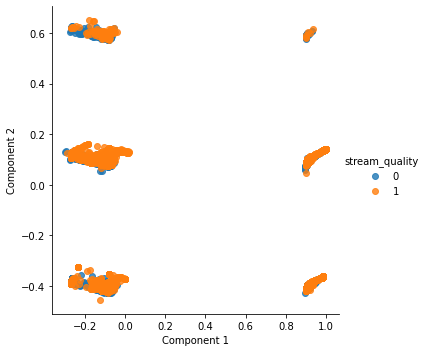

In [14]:
import seaborn as sns
from sklearn.decomposition import PCA


dim_reducer = PCA(n_components=2)
x_train_reduced = dim_reducer.fit_transform(scaled_data_train)
df_pca = pd.DataFrame(x_train_reduced, columns = ['Component1', 'Component2'])
df_pca['stream_quality'] = y_train


ax = sns.lmplot(x = 'Component1', y  = 'Component2', hue = 'stream_quality', data = df_pca, fit_reg = False)
ax.set_xlabels('Component 1')
ax.set_ylabels('Component 2')

#### Considering the categorical features

<AxesSubplot:xlabel='auto_fec_state', ylabel='Probability'>

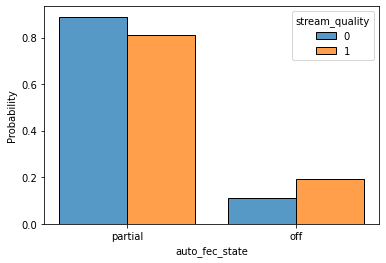

In [15]:
sns.histplot(
    data=df_train,
    x="auto_fec_state",
    hue="stream_quality",
    multiple="dodge",
    shrink=0.8,
    common_norm=False,
    stat="probability",
)

<AxesSubplot:xlabel='auto_bitrate_state', ylabel='Probability'>

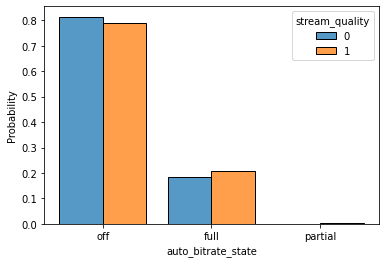

In [16]:
sns.histplot(
    data=df_train,
    x="auto_bitrate_state",
    hue="stream_quality",
    multiple="dodge",
    shrink=0.8,
    common_norm=False,
    stat="probability",
)

Considering the distributions of numeric features according to the classes

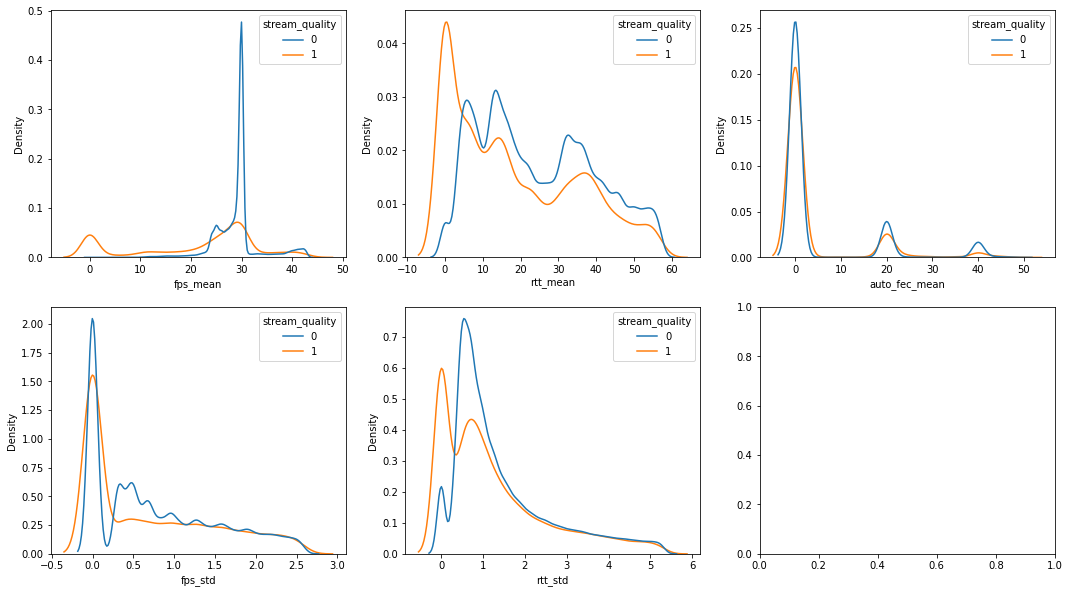

In [17]:
df = df_train.select_dtypes(exclude=["object"]).drop(
    [
        "stream_quality",
        "dropped_frames_std",
        "dropped_frames_max",
        "fps_lags",
        "dropped_frames_mean",
    ],
    axis=1,
)

n_plots = len(df.columns)
fig, ax = plt.subplots(2, int(n_plots / 2) + 1, figsize=[18, 10])

for i in range(0, n_plots, 2):

    name_i = df.iloc[:, i].name
    name_i_1 = df.iloc[:, i + 1].name if (i + 1) < n_plots else None

    sns.kdeplot(
        ax=ax[0][int(i / 2)],
        data=df_train,
        x=df_train[df_train[name_i] < df_train_describe.loc[name_i]["75%"]][name_i],
        hue="stream_quality",
        common_norm=False,
    )

    if (i + 1) < n_plots:
        sns.kdeplot(
            ax=ax[1][int(i / 2)],
            data=df_train,
            x=df_train[df_train[name_i_1] < df_train_describe.loc[name_i_1]["75%"]][
                name_i_1
            ],
            hue="stream_quality",
            common_norm=False,
        )

plt.show()

<AxesSubplot:xlabel='fps_lags', ylabel='Density'>

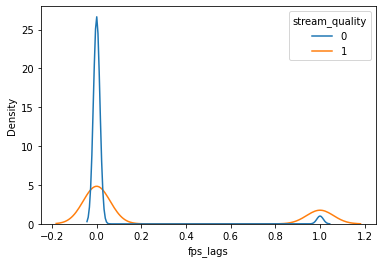

In [18]:
sns.kdeplot(
    data=df_train,
    x=df_train[df_train["fps_lags"] < 2]["fps_lags"],
    hue="stream_quality",
    common_norm=False,
)

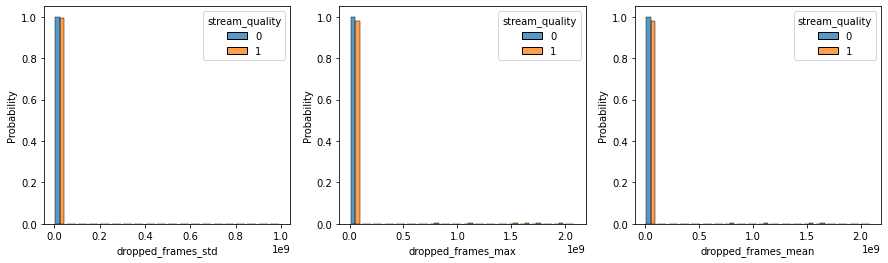

In [19]:
columns_name = ["dropped_frames_std","dropped_frames_max", "dropped_frames_mean"]
n_plots = 3
fig, ax = plt.subplots(1, 3, figsize=[15, 4])

for i in range(0, n_plots):

    sns.histplot(
        ax=ax[i],
        data=df_train,
        x=df_train[columns_name[i]],
        hue="stream_quality",
        common_norm=False,
        multiple = "dodge", 
        shrink = .8,
        stat = "probability"
    )

plt.show()

The main meaning is that if distributions of feature regarding target classes are different, then we can make an assumption that this feature has some impact on target. For example, "auto_fec_mean" has very similar distributions, it means that there is no obvious sign of dependence, however, it is possible that "auto_fec_mean" has an impact in a group with other features.

## 6. Feature Selection

In [20]:
len_df = len(scaled_data_train)
unique_vlaues_in_columns = scaled_data_train.nunique()

columns_with_constant_value = scaled_data_train.columns[unique_vlaues_in_columns <= 1]
print("Columns with constant value:", columns_with_constant_value.tolist())

threshold = 0.99
columns_with_distinct_values = scaled_data_train.columns[unique_vlaues_in_columns / len_df > threshold]
print(f"Columns with {threshold * 100} % distinct values: {columns_with_distinct_values.tolist()}")

Columns with constant value: []
Columns with 99.0 % distinct values: []


### Correlation

<AxesSubplot:>

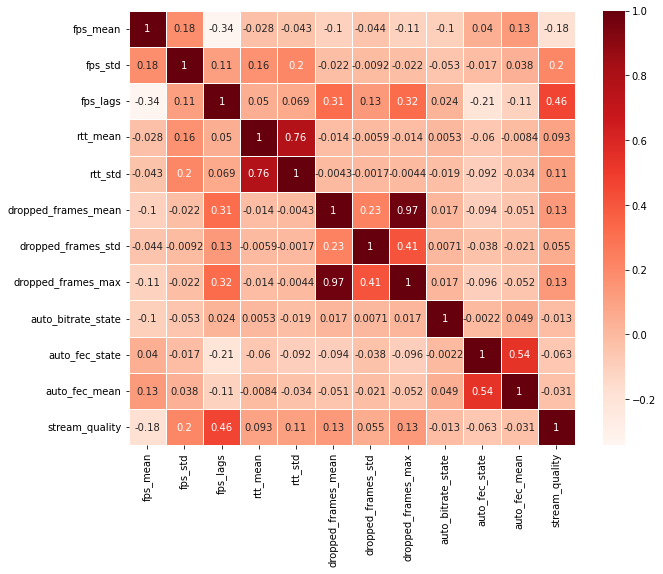

In [21]:
import seaborn as sns


fig, ax = plt.subplots(figsize=(10,8))        
sns.heatmap(df_train_encoded.corr(), annot=True, cmap=plt.cm.Reds, linewidths=.5, ax=ax)

### VIF- Variance Inflation Factor - measure of the amount of multicollinearity

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


# VIF dataFrame
vif_data = pd.DataFrame()
vif_data['feature'] = x_train.columns

# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(len(x_train.columns))]

print(vif_data)

                feature        VIF
0              fps_mean   6.422491
1               fps_std   1.550838
2              fps_lags   1.222571
3              rtt_mean   2.792360
4               rtt_std   2.500245
5   dropped_frames_mean  71.488734
6    dropped_frames_std   4.397023
7    dropped_frames_max  81.867632
8    auto_bitrate_state   4.218060
9        auto_fec_state   8.774668
10        auto_fec_mean   4.497278


We can see very large values for "dropped_max" and "dropped_mean". According to VIF, they have correlation with each other, what can be proved by looking at the correlation matrix as well.

### Lasso feature selection

In [23]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(penalty = 'l1', solver = 'liblinear').fit(scaled_data_train, y_train)
log.coef_

array([[-3.28128776, 35.25556813,  8.35392066,  7.66864364,  0.        ,
         0.        ,  0.        ,  0.87916225, -0.55743383,  0.52160638,
         0.13691467]])

We can see that Lasso chose only 3 feature as meaningless, that is "rtt_std", "dropped_frames_mean", and "dropped_frames_std".

In [24]:
# removing the features from training and test set
remove_columns = ["rtt_std", "dropped_frames_mean", "dropped_frames_std", "auto_fec_mean"]

x_train_reduced = scaled_data_train.drop(remove_columns, axis = 1)
x_test_reduced = scaled_data_test.drop(remove_columns, axis = 1)

print(f"\nThe shape of reduced training set: {x_train_reduced.shape}")
print(f"The shape of reduced test set: {x_test_reduced.shape}")


The shape of reduced training set: (406572, 7)
The shape of reduced test set: (243596, 7)


### VIF after reducing features

In [25]:
# VIF dataFrame
vif_data = pd.DataFrame()
vif_data['feature'] = x_train_reduced.columns

# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(x_train_reduced.values, i) for i in range(len(x_train_reduced.columns))]

print(vif_data)

              feature       VIF
0            fps_mean  6.374225
1             fps_std  1.525237
2            fps_lags  1.222469
3            rtt_mean  1.188913
4  dropped_frames_max  1.123947
5  auto_bitrate_state  4.212343
6      auto_fec_state  5.960917


After reducing multicollinear features VIF for some features is decreased.

# Machine Learning Models

In [46]:
import sklearn.metrics as sm 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [56]:
# function for printing metrics for classifications
def performance_measurement_classification(y_test, y_pred, y_train, y_train_pred, scores):
    """ This function prints MSE, MAE, RMSE and R^2-Score metrics for train and test datasets"""

    print("For Test:")
    print('Accuracy: ', sm.accuracy_score(y_test, y_pred))
    print('Precision: ', sm.precision_score(y_test, y_pred))
    print('Recall: ', sm.recall_score(y_test, y_pred))
    print("F1-Score:", sm.f1_score(y_test, y_pred))

    print("For Train:")
    print('Accuracy: ', sm.accuracy_score(y_train, y_train_pred))
    print('Precision: ', sm.precision_score(y_train, y_train_pred))
    print('Recall: ', sm.recall_score(y_train, y_train_pred))
    print("F1-Score:", sm.f1_score(y_train, y_train_pred))

    print("Cross Validation Scores:")
    print('Accuracy: ', np.mean(scores['test_accuracy']))
    print('Precision: ', np.mean(scores['test_precision']))
    print('Recall: ', np.mean(scores['test_recall']))
    print("F1-Score:", np.mean(scores['test_f1']))

### Logistic Regression

In [47]:
def logistic_regression(x_train, y_train, x_test, penalty="l2", solver="liblinear"):
    """
    Function for fitting and predicting by using logistic regression.
    penalty{'l1', 'l2', 'elasticnet', 'none'}, default='l2'
    solver{'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, default='lbfgs'
    """

    log_reg = LogisticRegression(penalty=penalty, solver=solver)
    log_reg.fit(x_train, y_train)
    y_pred_test = log_reg.predict(x_test)
    y_pred_train = log_reg.predict(x_train)

    # Evaluate the models using crossvalidation
    scores = cross_validate(log_reg, x_train, y_train,
                             scoring=["accuracy", "f1", "precision", "recall"], cv=10)

    return y_pred_test, y_pred_train, scores


In [57]:
y_pred_test_log1, y_pred_train_log1, scores_1 = logistic_regression(
    x_train_reduced, y_train, x_test_reduced, "none", "lbfgs"
)

performance_measurement_classification(
    y_test, y_pred_test_log1, y_train, y_pred_train_log1, scores_1
)

c:\Users\Айнура\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Айнура\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

For Test:
Accuracy:  0.9214888586019475
Precision:  0.384641248066707
Recall:  0.3644704982795973
F1-Score: 0.3742843121217078
For Train:
Accuracy:  0.9447231978591738
Precision:  0.834832583708146
Recall:  0.24006610620104907
F1-Score: 0.37290027345275967
Cross Validation Scores:
Accuracy:  0.9444231674320344
Precision:  0.7846904920269896
Recall:  0.23616190355235606
F1-Score: 0.33482818438321105


### Logistic Regression with L1 Regularization

In [58]:
y_pred_test_log2, y_pred_train_log2, scores_2 = logistic_regression(
    x_train_reduced, y_train, x_test_reduced, "l1", "liblinear"
)

performance_measurement_classification(
    y_test, y_pred_test_log2, y_train, y_pred_train_log2, scores_2
)

For Test:
Accuracy:  0.9215299101791491
Precision:  0.3844803133653002
Recall:  0.36275009557792787
F1-Score: 0.37329923609062
For Train:
Accuracy:  0.9447158190923133
Precision:  0.8403863260897192
Recall:  0.2375871236617087
F1-Score: 0.37044506063916194
Cross Validation Scores:
Accuracy:  0.9444920361405205
Precision:  0.7890866719467262
Recall:  0.23580243710789234
F1-Score: 0.3345143398129254


### Logistic Regression with L2 Regularization

In [59]:
y_pred_test_log3, y_pred_train_log3, scores_3 = logistic_regression(
    x_train_reduced, y_train, x_test_reduced, "l2", "liblinear"
)

performance_measurement_classification(
    y_test, y_pred_test_log3, y_train, y_pred_train_log3, scores_3
)

For Test:
Accuracy:  0.9280776367428036
Precision:  0.42385321100917434
Recall:  0.3238180196253345
F1-Score: 0.3671434763762462
For Train:
Accuracy:  0.9447896067609182
Precision:  0.8506704856138524
Recall:  0.23474886829057987
F1-Score: 0.3679572011825989
Cross Validation Scores:
Accuracy:  0.9446051777284502
Precision:  0.8020222846461402
Recall:  0.23249700046670885
F1-Score: 0.330705757107569


We can compare these models by identifying what mertic is more important for this particular task.
For our task the precision is more important, I think, because we don't want FalsePositives occurance.

Then Logistic Regression with L2 Regularization has better result than others. 

# Outlier Detection

In [37]:
from sklearn.neighbors import LocalOutlierFactor


lof = LocalOutlierFactor()
yhat = lof.fit_predict(x_train)

# select all rows that are not outliers
mask = yhat != -1
x_train_without_outliers, y_train_without_outliers = x_train[mask], y_train[mask]

Counting the percentage of outliers

In [38]:
unique_values, counts = np.unique(yhat, return_counts = True)
print(f"Unique values: {unique_values}, Amount accordingly: {counts}")

percentage =  counts[0] / len(x_train) * 100
print(f"The percentage of outliers is {percentage:.2f}%")

Unique values: [-1  1], Amount accordingly: [ 15651 390921]
The percentage of outliers is 3.85%


In [60]:
# scaling
scaled_train_without_outliers, scaled_test = scaler(
    MinMaxScaler, x_train_without_outliers, x_test
)

# removing the same features
x_train_reduced_without_outliers = scaled_train_without_outliers.drop(
    remove_columns, axis=1
)
x_test_reduced = scaled_test.drop(remove_columns, axis=1)

# logistic regression
y_pred_test_without_outliers, y_pred_train_without_outliers, scores_4 = logistic_regression(
    x_train_reduced_without_outliers,
    y_train_without_outliers,
    x_test_reduced,
    "none",
    "lbfgs",
)

performance_measurement_classification(
    y_test,
    y_pred_test_without_outliers,
    y_train_without_outliers,
    y_pred_train_without_outliers,
    scores_4
)

c:\Users\Айнура\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Айнура\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

For Test:
Accuracy:  0.9406065781047308
Precision:  0.6952229299363057
Recall:  0.13909774436090225
F1-Score: 0.23181480301582244
For Train:
Accuracy:  0.94636768042648
Precision:  0.8317703893151464
Recall:  0.22835075674832267
F1-Score: 0.35832772234804433
Cross Validation Scores:
Accuracy:  0.9461963066351269
Precision:  0.7758837386646718
Recall:  0.22677253949307405
F1-Score: 0.32166993666422494


Classifying without outliers decreased F1-Score.

## Balancing detecting

In [42]:
unique_values, counts = np.unique(y_train_without_outliers, return_counts = True)
print(f"Unique values: {unique_values}, Amount accordingly: {counts}")

Unique values: [0 1], Amount accordingly: [365285  25636]


We see that class "1" is less in the number of samples than class "0"

#### Undersampling

In [43]:
from imblearn.under_sampling import RandomUnderSampler


# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
x_train_rus, y_train_rus = rus.fit_resample(
    x_train_without_outliers, y_train_without_outliers
)

# Check the number of records after under sampling
unique_values, counts = np.unique(y_train_rus, return_counts=True)
print(f"Unique values: {unique_values}, Amount accordingly: {counts}")


Unique values: [0 1], Amount accordingly: [25636 25636]


In [61]:
# scaling
scaled_train_without_outliers, scaled_test = scaler(MinMaxScaler, x_train_rus, x_test)

# removing the dame features
x_train_reduced_without_outliers = scaled_train_without_outliers.drop(
    remove_columns, axis=1
)
x_test_reduced = scaled_test.drop(remove_columns, axis=1)

# logistic regression
y_pred_test_balanced, y_pred_train_balanced, scores_5 = logistic_regression(
    x_train_reduced_without_outliers, y_train_rus, x_test_reduced, "none", "lbfgs"
)

performance_measurement_classification(
    y_test, 
    y_pred_test_balanced, 
    y_train_rus, 
    y_pred_train_balanced, 
    scores_5
)

For Test:
Accuracy:  0.8826212253074763
Precision:  0.2758333043689827
Recall:  0.5056709570536511
F1-Score: 0.35695490835488586
For Train:
Accuracy:  0.7232017475425183
Precision:  0.857982982982983
Recall:  0.5349508503666719
F1-Score: 0.6590100913022586
Cross Validation Scores:
Accuracy:  0.7194393185323669
Precision:  0.8510670744320757
Recall:  0.5280119156385452
F1-Score: 0.6444902784577811


F1-Score is increased, what means that the undersampling helped us to improve our model.